<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_Helsinki_Air_Quality_EDA_%26_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Helsinki Kallio 2 Air Quality EDA Script ---

--- 1. Loading Data ---
Attempting to load data from: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Reading CSV with manual headers, skipping first row, using COMMA separator...
Successfully loaded data.

--- 2. Cleaning and Preparing Data ---
Creating Timestamp column...
Timestamp column created.
Converting 'Otsoni [µg/m³]' column to numeric...
Otsoni column converted.
Setting Timestamp as DataFrame index...
Index set and sorted.

--- 3. Basic Exploratory Data Analysis (Text) ---

--- First 5 Rows (Head) ---
                         Havaintoasema Vuosi Kuukausi Päivä  \
Timestamp                                                     
2020-04-01 00:00:00  Helsinki Kallio 2  2020       04    01   
2020-04-01 01:00:00  Helsinki Kallio 2  2020       04    01   
2020-04-01 02:00:00  Helsinki Kallio 2  2020       04  

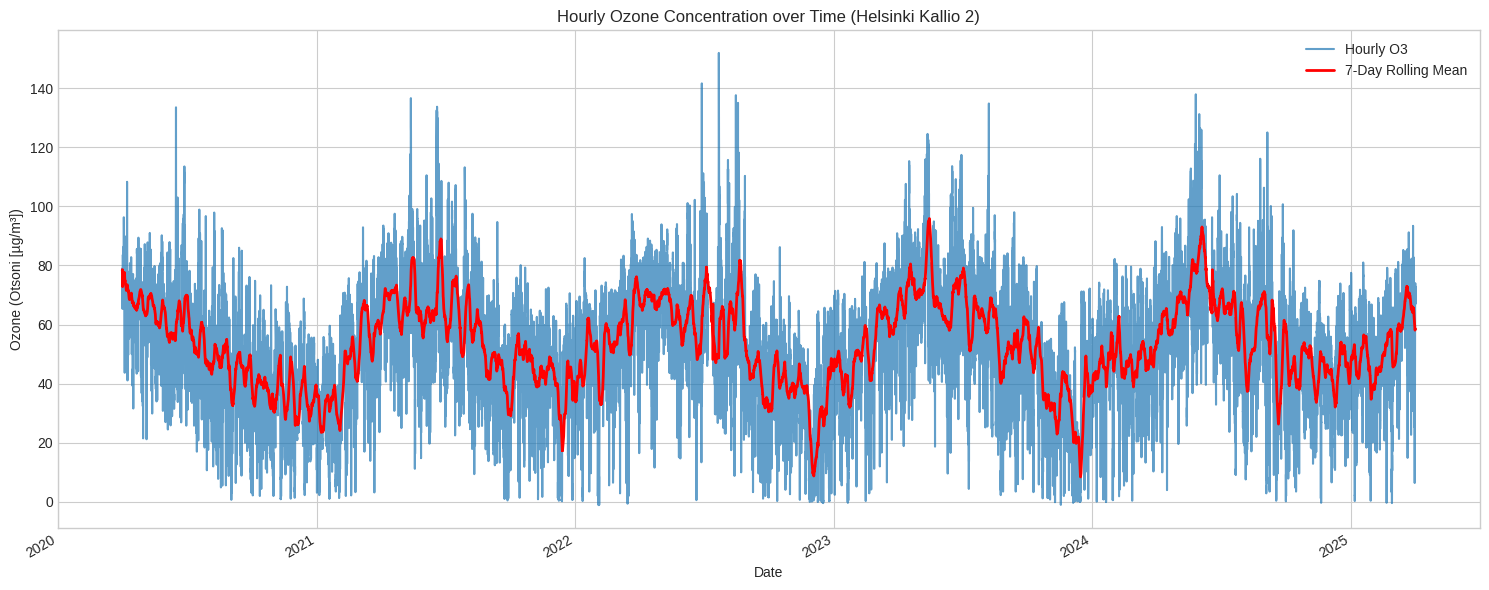

Time series plot generated.

Plotting Ozone distribution...


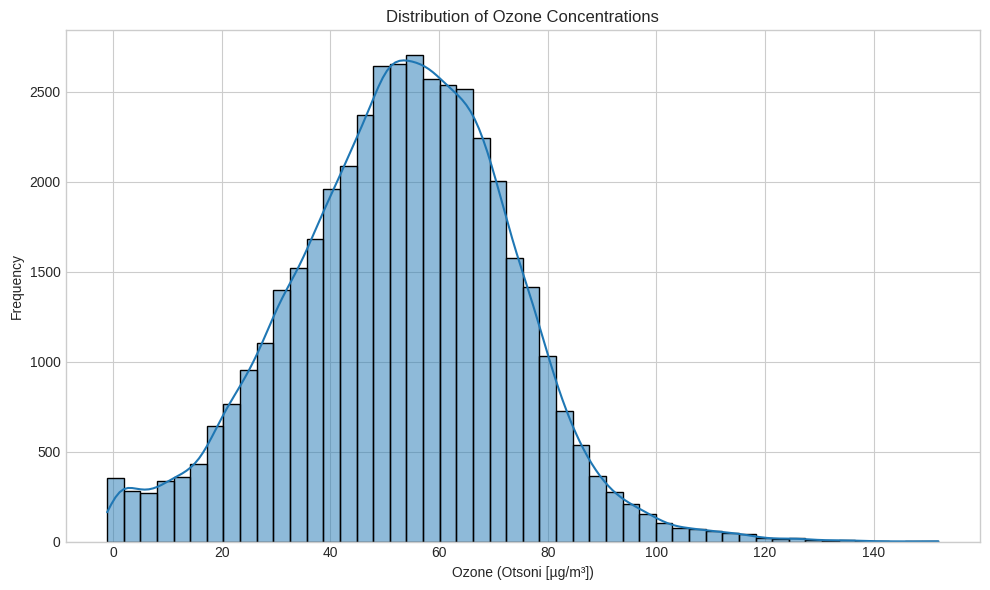

Distribution plot generated.

Plotting Ozone distribution by Year...


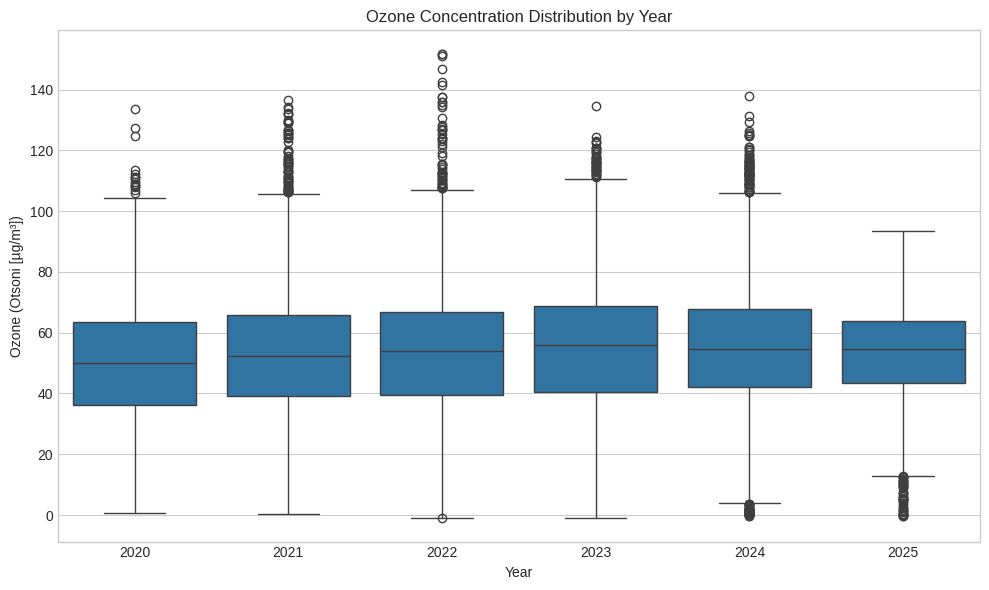

Box plot by year generated.

Plotting Ozone distribution by Month...


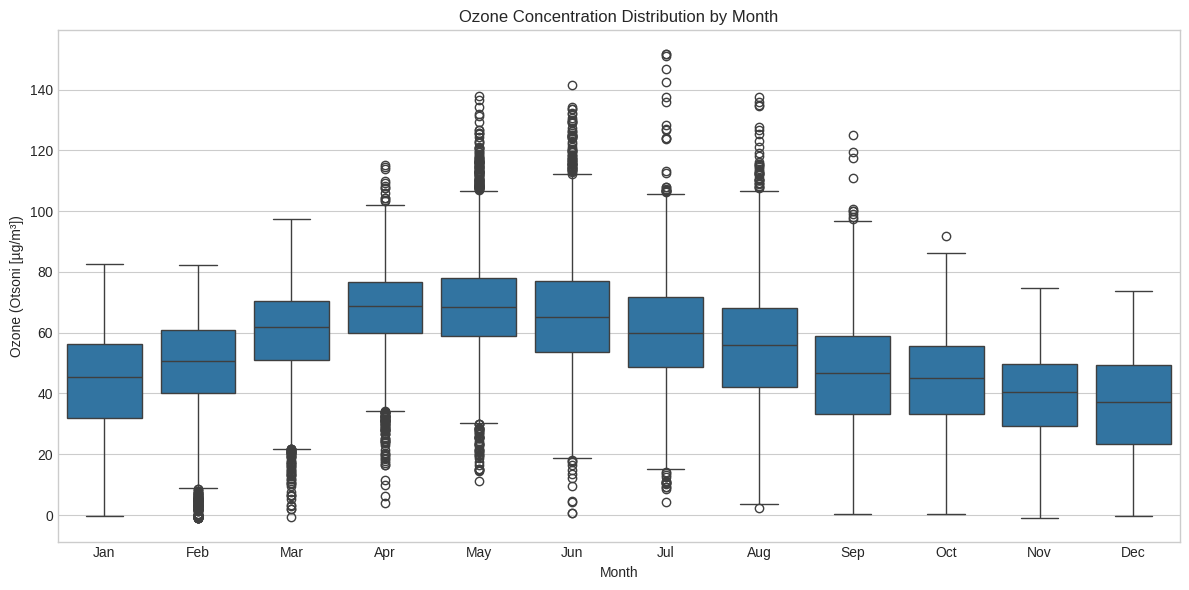

Box plot by month generated.

--- EDA Script Finished ---


In [1]:
# -*- coding: utf-8 -*-
"""
EDA Script for Helsinki Kallio 2 Air Quality Data (for Google Colab)

Loads data, cleans it, performs basic EDA, and creates visualizations.
"""

# Import necessary libraries
import pandas as pd
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # For error reporting

print("--- Helsinki Kallio 2 Air Quality EDA Script ---")

# --- 1. Data Loading and Initial Setup ---
print("\n--- 1. Loading Data ---")

# Construct the raw URL
raw_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
print(f"Attempting to load data from: {raw_url}")

# Define column names manually (using correct characters)
column_names = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
o3_col_name = "Otsoni [µg/m³]" # Store the target column name

df = None # Initialize df to None

try:
    # Fetch the content from the URL
    response = requests.get(raw_url)
    response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

    # Use io.StringIO to read the text content like a file
    # Use iso-8859-1 encoding, COMMA separator, comma decimal
    # Skip the first row (problematic header) and assign manual names
    print("Reading CSV with manual headers, skipping first row, using COMMA separator...")
    csv_content = io.StringIO(response.content.decode('iso-8859-1'))
    df = pd.read_csv(
        csv_content,
        sep=',', # Using COMMA separator
        decimal=',',
        skiprows=1, # Skip the faulty header row
        header=None, # No header row in the data itself now
        names=column_names, # Assign the correct names
        quoting=csv.QUOTE_NONNUMERIC # Handle fields enclosed in quotes
    )
    print("Successfully loaded data.")

    # --- 2. Data Cleaning & Preparation ---
    print("\n--- 2. Cleaning and Preparing Data ---")

    # 2a. Combine date and time columns into a single datetime column
    print("Creating Timestamp column...")
    try:
        # Ensure components are strings before concatenation
        df['Vuosi'] = df['Vuosi'].astype(float).astype('Int64').astype(str)
        df['Kuukausi'] = df['Kuukausi'].astype(float).astype('Int64').astype(str).str.zfill(2)
        df['Päivä'] = df['Päivä'].astype(float).astype('Int64').astype(str).str.zfill(2)
        df['Aika [Paikallinen aika]'] = df['Aika [Paikallinen aika]'].astype(str)

        # Handle '24:00' time format -> next day 00:00
        time_str = df['Aika [Paikallinen aika]'].str.replace('24:00', '00:00', regex=False)
        datetime_str = df['Vuosi'] + '-' + df['Kuukausi'] + '-' + df['Päivä'] + ' ' + time_str
        df['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df.loc[df['Aika [Paikallinen aika]'] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)

        parsing_errors = df['Timestamp'].isnull().sum()
        if parsing_errors > 0:
            print(f"Warning: {parsing_errors} rows resulted in NaT during timestamp creation.")
        print("Timestamp column created.")

    except Exception as e:
        print(f"Error creating timestamp column: {e}")
        df['Timestamp'] = pd.NaT # Assign NaT if creation failed

    # 2b. Convert Otsoni column to numeric
    print(f"Converting '{o3_col_name}' column to numeric...")
    initial_nulls = df[o3_col_name].isnull().sum()
    if o3_col_name in df.columns:
        # Replace comma decimal with dot, then convert
        df[o3_col_name] = df[o3_col_name].astype(str).str.replace(',', '.', regex=False)
        df[o3_col_name] = pd.to_numeric(df[o3_col_name], errors='coerce')
        final_nulls = df[o3_col_name].isnull().sum()
        new_nulls = final_nulls - initial_nulls
        if new_nulls > 0:
             print(f"Warning: {new_nulls} values in '{o3_col_name}' converted to NaN (Total NaNs: {final_nulls}).")
        elif final_nulls > 0 :
             print(f"Note: Column '{o3_col_name}' already contained {final_nulls} NaN values.")
        print("Otsoni column converted.")
    else:
        print(f"Error: Column '{o3_col_name}' not found.")

    # 2c. Set Timestamp as index (useful for time series analysis/plotting)
    print("Setting Timestamp as DataFrame index...")
    df.set_index('Timestamp', inplace=True, drop=True) # drop=True removes the original Timestamp column
    # Sort index for proper time series plotting
    df.sort_index(inplace=True)
    print("Index set and sorted.")

    # --- 3. Basic Text EDA ---
    print("\n--- 3. Basic Exploratory Data Analysis (Text) ---")

    print("\n--- First 5 Rows (Head) ---")
    print(df.head())

    print("\n--- Data Info (Types, Non-Null Counts) ---")
    # df.info() prints directly, capture in buffer if needed elsewhere
    df.info()

    print("\n--- Missing Value Counts ---")
    print(df.isnull().sum())

    print("\n--- Summary Statistics ---")
    # include='all' describes all columns
    print(df.describe(include='all'))


    # --- 4. Basic Visualizations ---
    print("\n--- 4. Generating Visualizations ---")
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean seaborn style

    # 4a. Time Series Plot of Ozone
    print("Plotting Ozone time series...")
    try:
        plt.figure(figsize=(15, 6))
        # Plot directly from the DataFrame index (Timestamp)
        df[o3_col_name].plot(alpha=0.7, label='Hourly O3')
        # Add rolling mean for trend visibility (e.g., 7-day rolling average)
        df[o3_col_name].rolling('7D').mean().plot(label='7-Day Rolling Mean', color='red', linewidth=2)

        plt.title('Hourly Ozone Concentration over Time (Helsinki Kallio 2)')
        plt.xlabel('Date')
        plt.ylabel(f'Ozone ({o3_col_name})')
        plt.legend()
        plt.tight_layout()
        plt.show()
        print("Time series plot generated.")
    except Exception as e:
        print(f"Error generating time series plot: {e}")

    # 4b. Distribution of Ozone
    print("\nPlotting Ozone distribution...")
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[o3_col_name].dropna(), kde=True, bins=50) # dropna() is important
        plt.title('Distribution of Ozone Concentrations')
        plt.xlabel(f'Ozone ({o3_col_name})')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
        print("Distribution plot generated.")
    except Exception as e:
        print(f"Error generating distribution plot: {e}")

    # 4c. Box Plot of Ozone by Year
    print("\nPlotting Ozone distribution by Year...")
    try:
        plt.figure(figsize=(10, 6))
        # Extract year from the index (Timestamp) for grouping
        sns.boxplot(x=df.index.year, y=df[o3_col_name])
        plt.title('Ozone Concentration Distribution by Year')
        plt.xlabel('Year')
        plt.ylabel(f'Ozone ({o3_col_name})')
        plt.tight_layout()
        plt.show()
        print("Box plot by year generated.")
    except Exception as e:
        print(f"Error generating box plot by year: {e}")

    # 4d. Box Plot of Ozone by Month
    print("\nPlotting Ozone distribution by Month...")
    try:
        plt.figure(figsize=(12, 6))
         # Extract month from the index (Timestamp) for grouping
        sns.boxplot(x=df.index.month, y=df[o3_col_name])
        plt.title('Ozone Concentration Distribution by Month')
        plt.xlabel('Month')
        plt.ylabel(f'Ozone ({o3_col_name})')
        # Optional: Set month names as labels
        plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.tight_layout()
        plt.show()
        print("Box plot by month generated.")
    except Exception as e:
        print(f"Error generating box plot by month: {e}")


except requests.exceptions.RequestException as e:
    print(f"FATAL ERROR: Could not fetch data from URL. {e}")
except pd.errors.EmptyDataError:
    print("FATAL ERROR: The CSV file appears to be empty.")
except ImportError as e:
    print(f"FATAL ERROR: Missing required library. {e}")
except Exception as e:
    print(f"An unexpected FATAL error occurred: {e}")
    print("Traceback:")
    traceback.print_exc()
finally:
    if df is not None:
         print("\n--- EDA Script Finished ---")
    else:
         print("\n--- EDA Script Finished with Errors (Dataframe not loaded) ---")